# Generating synthetic time series from ENTSO-E data

This notebook explains how synthetic time series can be generated from data publicly available at https://transparency.entsoe.eu/.

Let us start with importing the `time_series` and `entso-e` modules:

In [1]:
import os, sys
sys.path.append('../TimeSeries/')

import time_series as ts
import entso_e

The notebook also uses a few other standard modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Fetch ENTSO-E data

The first step is to download the data from the ENTSO-E. This is most conveniently done using Secure File Transfer Protocol (SFTP), as explained in the [ENTSO-E guide](https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/SFTP-Transparency_Docs.html).

Create an account at https://transparency.entsoe.eu/.
Then, choose a directory where you want to place the raw data, for instance

```console
cd ~/data/entso-e/raw
```

Save the path to your data folder in the following variable:

In [3]:
data_source = os.path.expanduser('~/data/entso-e/raw')

Connect to ENTSO-E transparency database with secure FTP:

```console
$ sftp <email>@sftp-transparency.entsoe.eu
```

Enter your password as requested. You can then parse the data, e.g. the total load for the year 2023 is found at:

```console
sftp> ls /TP_export/ActualTotalLoad_6.1.A/2023*
```

There are 12 files that can be downloaded using:

```console
sftp> get /TP_export/ActualTotalLoad_6.1.A/2023*
```

Once you have all the data you need, close the FTP connection with

```console
sftp> exit
```

## Extract yearly time series

The second step is to extract yearly time series from the raw ENTSO-E data. This can be done using the module `entso_e`.

For example, if we are interested in the total load for Switzerland in 2023, with hourly time steps, we can use:

In [4]:
load_CH_2023 = entso_e.extract_load_time_series(data_source, 'CH', 2023, 24)

  0%|          | 0/12 [00:00<?, ?it/s]

The result is a list of length 365 x 24:

In [5]:
len(load_CH_2023) == 365 * 24

True

Similarly, the total load for Germany in 2016, with 15-minute time steps (96 steps per day) is obtained using:

In [6]:
load_DE_2016 = entso_e.extract_load_time_series(data_source, 'DE', 2016, 96)

  0%|          | 0/12 [00:00<?, ?it/s]

It has length 366 x 24 x 4 (2016 is a leap year):

In [7]:
len(load_DE_2016) == 366 * 24 * 4

True

Other types of time series can be extracted, such as border flows between countries, in either direction:

In [8]:
border_flow_FR_export_to_ES_2020 = entso_e.extract_border_flow_time_series(data_source, 'FR', 'ES', 2020)
border_flow_FR_import_from_ES_2020 = entso_e.extract_border_flow_time_series(data_source, 'ES', 'FR', 2020)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
border_flow_FR_to_ES_2020 = np.array(border_flow_FR_export_to_ES_2020) - np.array(border_flow_FR_import_from_ES_2020)

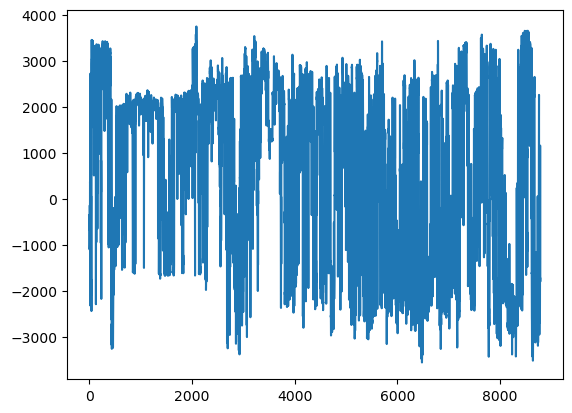

In [10]:
plt.plot(border_flow_FR_to_ES_2020)
plt.show()

...or production by type:

In [11]:
nuclear_production_FR_2018 = entso_e.extract_production_by_type_time_series(data_source, 'Nuclear', 'FR', 2018)

  0%|          | 0/12 [00:00<?, ?it/s]

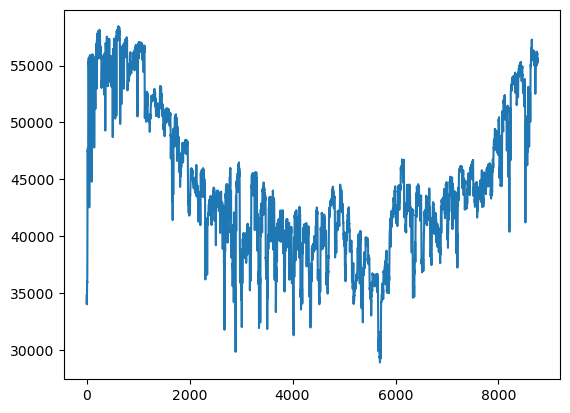

In [12]:
plt.plot(nuclear_production_FR_2018)
plt.show()

## Transform into periodic series

The data can be turned into periodic series starting on the first Monday in January:

In [13]:
load_CH_2023_periodic = ts.make_364_periodic(load_CH_2023, 2023)

Cropping regular year (365 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 1 days to make it start on a Monday


If the year is not specified, the function determines by itself the position of the first Monday using the periodicity properties of the time series (Saturdays and Sundays have generally different profiles than weekdays):

In [14]:
load_DE_2016_periodic = ts.make_364_periodic(load_DE_2016)

Cropping leap year (366 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 3 days to make it start on a Monday


Plot a winter and a sommer week:

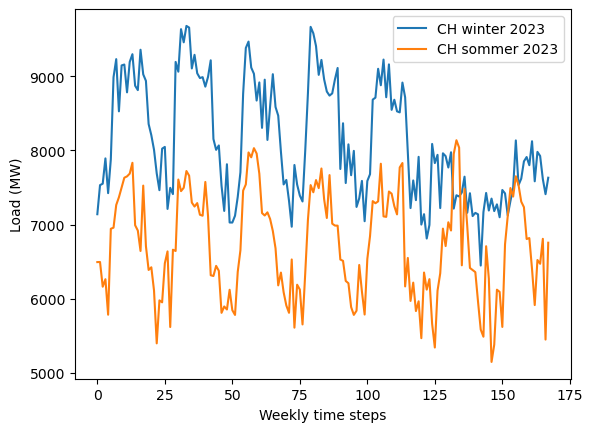

In [15]:
plt.plot(load_CH_2023_periodic[7*24:2*7*24], label='CH winter 2023')
plt.plot(load_CH_2023_periodic[26*7*24:27*7*24], label='CH sommer 2023')
plt.xlabel('Weekly time steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

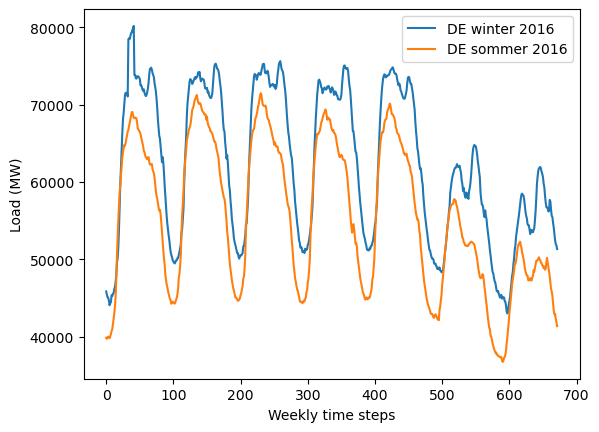

In [16]:
plt.plot(load_DE_2016_periodic[7*24*4:2*7*24*4], label='DE winter 2016')
plt.plot(load_DE_2016_periodic[26*7*24*4:27*7*24*4], label='DE sommer 2016')
plt.xlabel('Weekly time steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

Weekly average over a year:

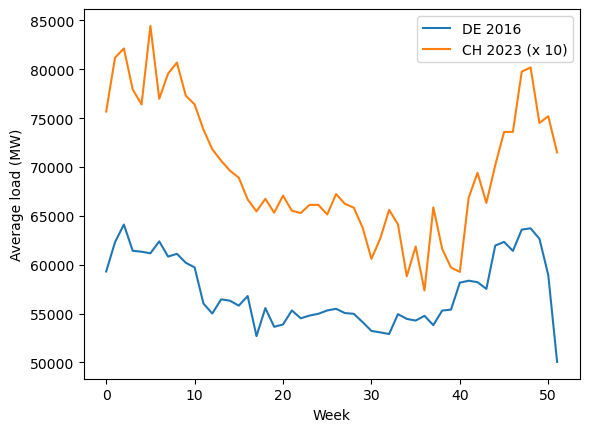

In [17]:
plt.plot(load_DE_2016_periodic.reshape(52, -1).mean(axis=1), label='DE 2016')
plt.plot(10 * load_CH_2023_periodic.reshape(52, -1).mean(axis=1), label='CH 2023 (x 10)')
plt.xlabel('Week')
plt.ylabel('Average load (MW)')
plt.legend()
plt.show()

## Compare multiple years

We can extract several years' worth of data by passing a list of years in the function:

In [18]:
CH_load_2015_2023 = entso_e.extract_load_time_series(data_source, 'CH', list(range(2015, 2024)))

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

We make the series periodic:

In [19]:
CH_load_2015_2023_periodic = np.array([ts.make_364_periodic(time_series) for time_series in CH_load_2015_2023])

Cropping regular year (365 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 4 days to make it start on a Monday
Cropping leap year (366 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 3 days to make it start on a Monday
Cropping regular year (365 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 1 days to make it start on a Monday
Cropping regular year (365 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 0 days to make it start on a Monday
Cropping regular year (365 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 6 days to make it start on a Monday
Cropping leap year (366 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 5 days to make it start on a Monday
Cropping regular year (365 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 3 days to make it start on a Monday
Cropping regular year (365 days) to 364 = 52 weeks * 7 days.
Rolling the series backward by 2 days to make it 

...and compute the mean value:

In [20]:
CH_load_avg_periodic = CH_load_2015_2023_periodic.mean(axis = 0)

In [21]:
CH_load_2015_2023_periodic.shape

(9, 8736)

In [22]:
CH_load_2015_2023_periodic[5:, 7*24:2*7*24].shape

(4, 168)

This is what a typical winter week looks like:

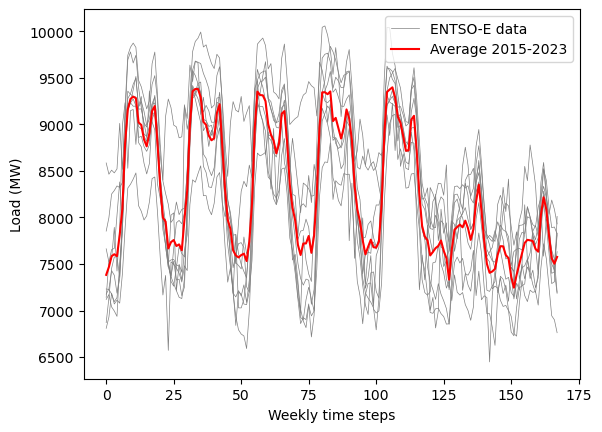

In [23]:
plt.plot(CH_load_2015_2023_periodic[:, 7*24:2*7*24].transpose(), color='gray', linewidth=0.5,
         label=['ENTSO-E data' if i == 0 else '' for i in range(CH_load_2015_2023_periodic.shape[0])])
plt.plot(CH_load_avg_periodic[7*24:2*7*24], label='Average 2015-2023', color='red')
plt.xlabel('Weekly time steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

## Create a statistical model

A statistical model can be created from a list of time series (this takes some times as it requires to compute the square root of a pretty large covariance matrix):

In [24]:
CH_load_model = ts.create_model(CH_load_2015_2023_periodic)

Computing the Cholesky decomposition of a 8736 x 8736 matrix (this may take some time)


The model can be saved in `.npz` format:

In [25]:
ts.export_model('data/entsoe_load_CH_2015_2023', CH_load_model)

## Use the model

In [26]:
CH_load_model = ts.import_model('data/entsoe_load_CH_2015_2023.npz')

Synthetic time series are generated efficiently:

In [27]:
CH_load_synthetic = ts.generate_time_series(CH_load_model, 3)

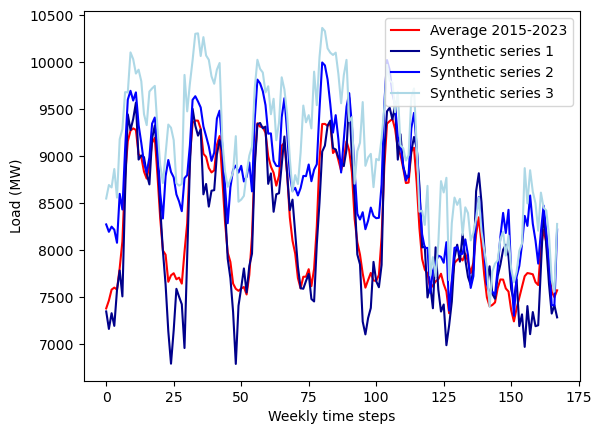

In [28]:
plt.plot(CH_load_avg_periodic[7*24:2*7*24], label='Average 2015-2023', color='red')
plt.plot(CH_load_synthetic[0, 7*24:2*7*24], label='Synthetic series 1', color='darkblue')
plt.plot(CH_load_synthetic[1, 7*24:2*7*24], label='Synthetic series 2', color='blue')
plt.plot(CH_load_synthetic[2, 7*24:2*7*24], label='Synthetic series 3', color='lightblue')
plt.xlabel('Weekly time steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

The standard deviation can be increased to generate more extreme situations:

In [29]:
CH_load_synthetic_extreme = ts.generate_time_series(CH_load_model, 3, std_scaling=2.0)

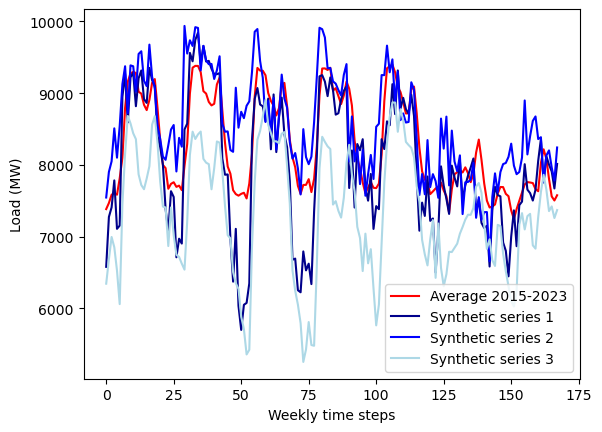

In [30]:
plt.plot(CH_load_avg_periodic[7*24:2*7*24], label='Average 2015-2023', color='red')
plt.plot(CH_load_synthetic_extreme[0, 7*24:2*7*24], label='Synthetic series 1', color='darkblue')
plt.plot(CH_load_synthetic_extreme[1, 7*24:2*7*24], label='Synthetic series 2', color='blue')
plt.plot(CH_load_synthetic_extreme[2, 7*24:2*7*24], label='Synthetic series 3', color='lightblue')
plt.xlabel('Weekly time steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

The series can also be normalized as follows:

In [31]:
CH_load_synthetic_normalized = ts.generate_time_series(CH_load_model, std_scaling=0.0, normalize=True)

In [32]:
CH_load_synthetic_normalized.mean()

1.0

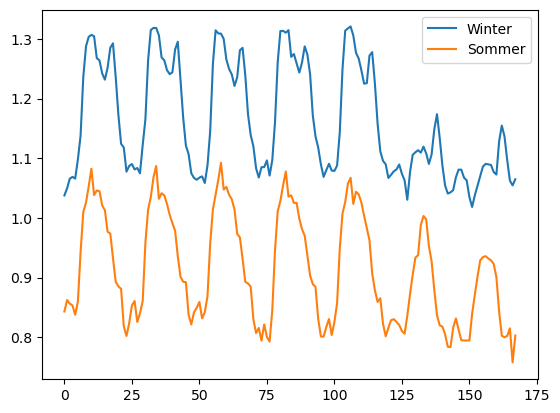

In [33]:
plt.plot(CH_load_synthetic_normalized[0, 7*24:2*7*24], label='Winter')
plt.plot(CH_load_synthetic_normalized[0, 26*7*24:27*7*24], label='Sommer')
plt.legend()
plt.show()

More advanced figure:

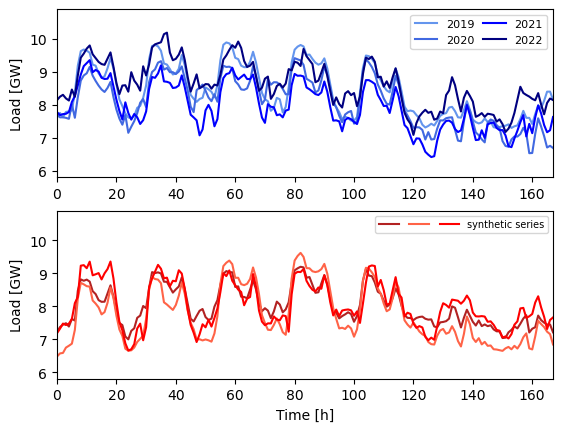

In [59]:
week = 4
xrange = range(week*7*24, (week+1)*7*24)

fig, (ax1, ax2) = plt.subplots(2)
plt.subplots_adjust(hspace=0.2)

blue_colors = ['cornflowerblue', 'royalblue', 'blue', 'navy']

for i in range(4):
    ax1.plot([t for t in range(168)], CH_load_2015_2023_periodic[4 + i, xrange].transpose() / 1000,
             color = blue_colors[i], label='%d' % (2019 + i))
ax1.set_xlim(0, 167)
ax1.set_ylim(5.8, 10.9)
ax1.set_ylabel('Load [GW]')
ax1.legend(loc='upper right', prop={'size': 8}, ncols=2, columnspacing=0.8)
# ax1.set_title('Switzerland total load, winter week, 2020 - 2023')

# for i in range(4):
#     ax2.plot([t for t in range(168)], CH_load_2015_2023_periodic[5 + i, xrange].transpose() / 1000,
#              color = blue_colors[i], alpha = 0.3)
red_colors = ['firebrick', 'tomato', 'red']
for i in range(3):
    ax2.plot([t for t in range(168)], ts.generate_time_series(CH_load_model)[0, xrange] / 1000,
             color = red_colors[i], label=('synthetic series' if i == 2 else ' '))
ax2.set_xlim(0, 167)
ax2.set_ylim(5.8, 10.9)
ax2.set_ylabel('Load [GW]')
ax2.legend(loc='upper right', prop={'size': 7}, ncols=3, columnspacing=0)
# ax2.set_title('Synthetic series based on statistical model')
ax2.set_xlabel('Time [h]')

fig.savefig('figures/synthetic_series_example.pdf')

## Correlation before and after Fourier transform

Compute the correlation coefficients between the time steps of the selected week, both for the original series and its Fourier transform:

In [60]:
selected_loads = CH_load_2015_2023_periodic[:, xrange]

corr = np.corrcoef(selected_loads, rowvar=False)
corr_ft = np.corrcoef(ts.fourier_transform(selected_loads), rowvar=False)

Visualize the correlation matrices:

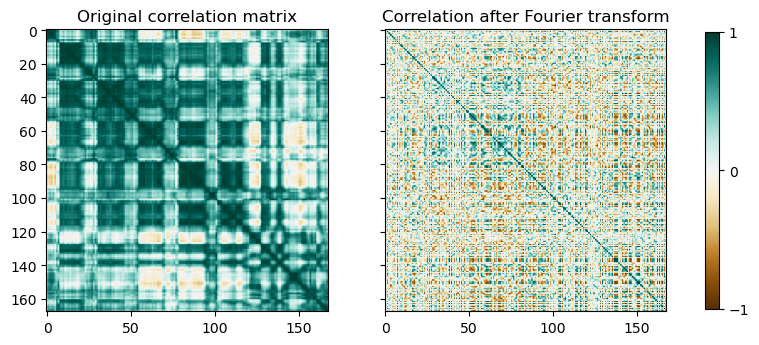

In [61]:
colormap = 'BrBG'
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axes[0].imshow(corr, vmin=-1, vmax=1, cmap=colormap)
axes[0].set_title('Original correlation matrix')
im = axes[1].imshow(corr_ft, vmin=-1, vmax=1, cmap=colormap)
axes[1].set_title('Correlation after Fourier transform')
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9, ticks=[-1, 0, 1])
# cbar.set_label('Correlation')
plt.savefig('figures/correlation_and_FT.pdf', dpi=300, bbox_inches='tight')
plt.show()

Add the variance in the same figure;

In [62]:
variance = np.var(selected_loads, axis=0)
variance_ft = np.var(ts.fourier_transform(selected_loads), axis=0)

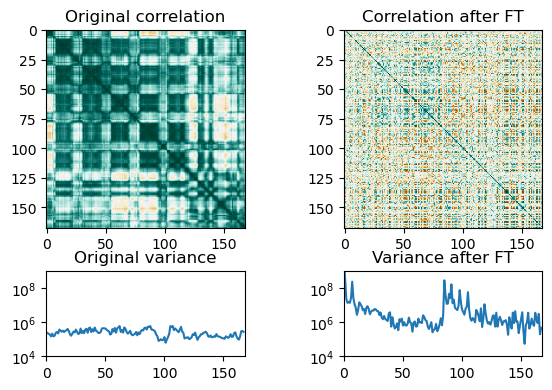

In [63]:
import matplotlib.gridspec as grd

grid = grd.GridSpec(2, 2, height_ratios=[10,3], width_ratios=[10, 10], wspace=0.5, hspace=0)

ax00 = plt.subplot(grid[0])
ax00.imshow(corr, vmin=-1, vmax=1, cmap=colormap, aspect=1)
ax00.set_title('Original correlation')

ax01 = plt.subplot(grid[1])
im = ax01.imshow(corr_ft, vmin=-1, vmax=1, cmap=colormap, aspect=1)
ax01.set_title('Correlation after FT')

# ax02 = plt.subplot(grid[2])
# cbar = fig.colorbar(im, cax=ax02, ticks=[-1, 0, 1])

ax10 = plt.subplot(grid[2])
ax10.plot(variance)
ax10.set_yscale('log')
ax10.set_xlim(0, 7*24)
ax10.set_ylim(1e4, 1e9)
ax10.set_title('Original variance')

ax11 = plt.subplot(grid[3])
ax11.plot(variance_ft)
ax11.set_yscale('log')
ax11.set_xlim(0, 7*24)
ax11.set_ylim(1e4, 1e9)
ax11.set_title('Variance after FT')
plt.show()